<a id='top'></a>

# Loan Default Prediction
## Geekbrains AI/BigData Loan Default Prediction Competition

#### Data Description

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный скоринг 
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Load Modules

In [1]:
import os
import zipfile

import math
import numpy as np
import pandas as pd

import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
import catboost as catb
import lightgbm as lgbm
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBRegressor


TARGET = 'Credit Default'

#### Settings

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.options.display.float_format = '{:.2f}'.format

FIGSIZE = (15, 20)

In [5]:
test = pd.read_csv("course_project_test.csv")
train = pd.read_csv("course_project_train.csv")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
print(f'Training data shape: {train.shape}')
train.head()

Training data shape: (7500, 17)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,nan,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,nan,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,nan,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,nan,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,nan,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [8]:
print(f'Testing data shape: {test.shape}')
test.head()

Testing data shape: (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,nan,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,nan
1,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,nan,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,nan,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


#### Memory use optimization

In [9]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [10]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [12]:
train = optimizing_df(train)
test = optimizing_df(test)

In [13]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [14]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

<a id=explore></a>
### Exploratory Data Analysis

#### Examine the Distribution of the Target Column

In [15]:
train[TARGET].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

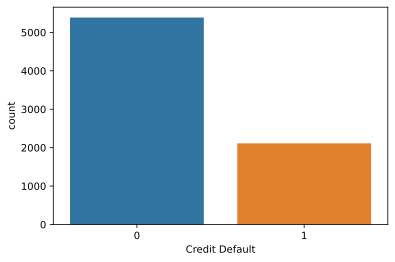

In [16]:
sns.countplot(x=TARGET, data=train)

#### Initial Exploration

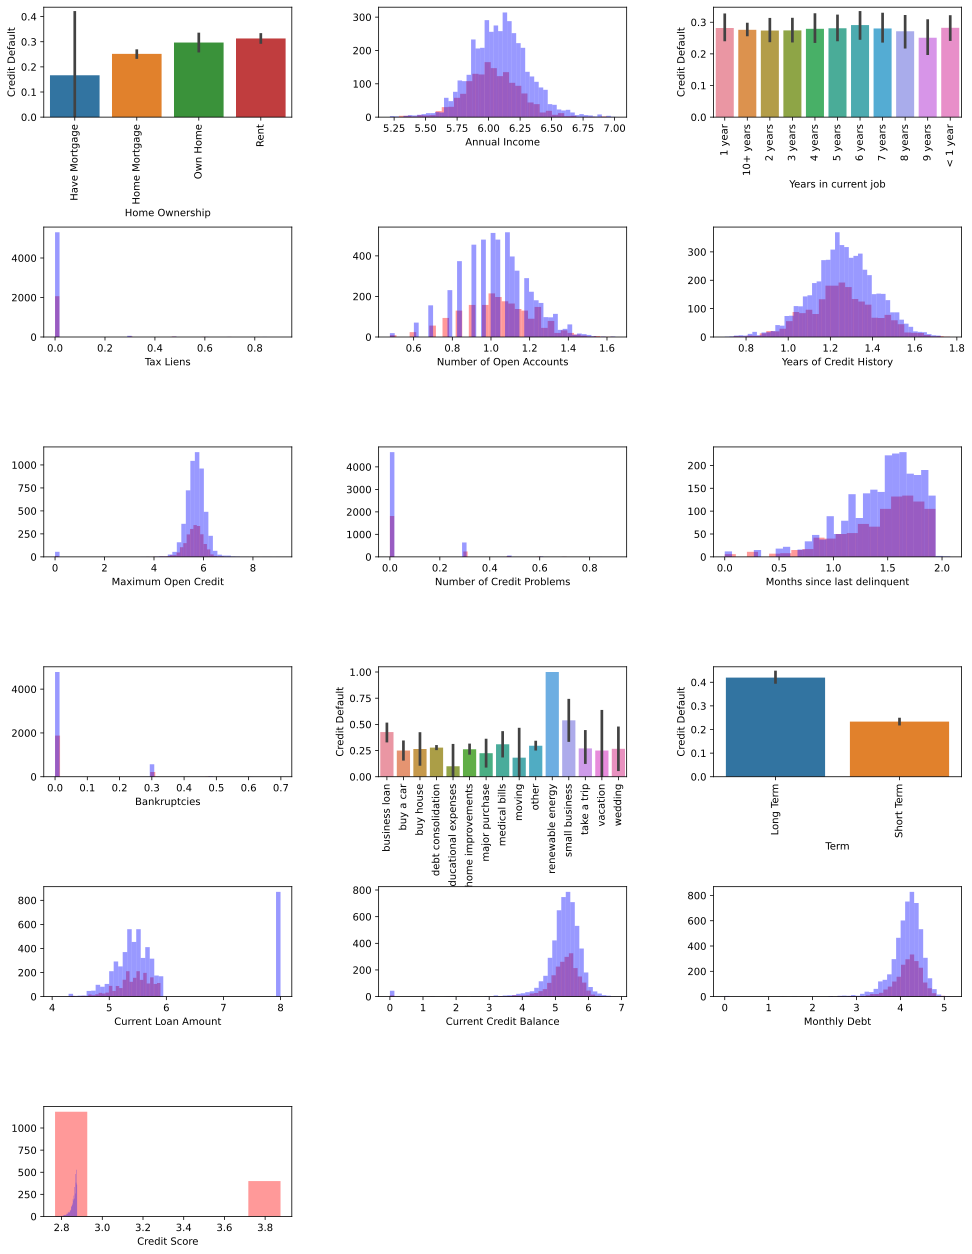

In [17]:
cat_list = list(train.loc[:, ~train.columns.isin(['Id', 'Credit Default'])])

ncols = 3
nrows = math.ceil(len(cat_list) / ncols)
index = 1

default_col = 'red'
nodefault_col = 'blue'

fig,ax = plt.subplots(figsize=FIGSIZE, ncols=1)

for col_name in cat_list:
    plt.subplot(nrows, ncols, index)
    index += 1
    
    if train[col_name].dtypes.kind == 'O':
        g = sns.barplot(x=col_name, y=TARGET, data=train)
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    else:
        sns.distplot(np.log10(train[train[TARGET] == 1][col_name].dropna().values+1), kde=False, color=default_col)
        sns.distplot(np.log10(train[train[TARGET] == 0][col_name].dropna().values+1), kde=False, color=nodefault_col, axlabel=col_name)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1, wspace=0.35)
ax.autoscale(enable=True) 
plt.show()

In [18]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop([TARGET], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (10000, 16)


In [19]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,7930.00,1366525.00,863828.38,106533.00,845989.25,1168813.50,1638693.00,14975610.00
Tax Liens,10000.00,0.03,0.30,0.00,0.00,0.00,0.00,15.00
Number of Open Accounts,10000.00,11.14,4.89,1.00,8.00,10.00,14.00,48.00
Years of Credit History,10000.00,18.32,7.10,3.90,13.50,17.00,22.00,57.70
Maximum Open Credit,10000.00,886506.88,13899728.00,0.00,278811.50,478181.00,794359.50,1304726144.00
Number of Credit Problems,10000.00,0.17,0.51,0.00,0.00,0.00,0.00,15.00
Months since last delinquent,4561.00,34.56,21.77,0.00,16.00,32.00,50.00,118.00
Bankruptcies,9983.00,0.11,0.35,0.00,0.00,0.00,0.00,5.00
Current Loan Amount,10000.00,11943762.00,32008752.00,11242.00,180548.50,311718.00,521070.00,100000000.00
Current Credit Balance,10000.00,291474.00,333997.28,0.00,113225.75,209019.00,361950.00,6506797.00


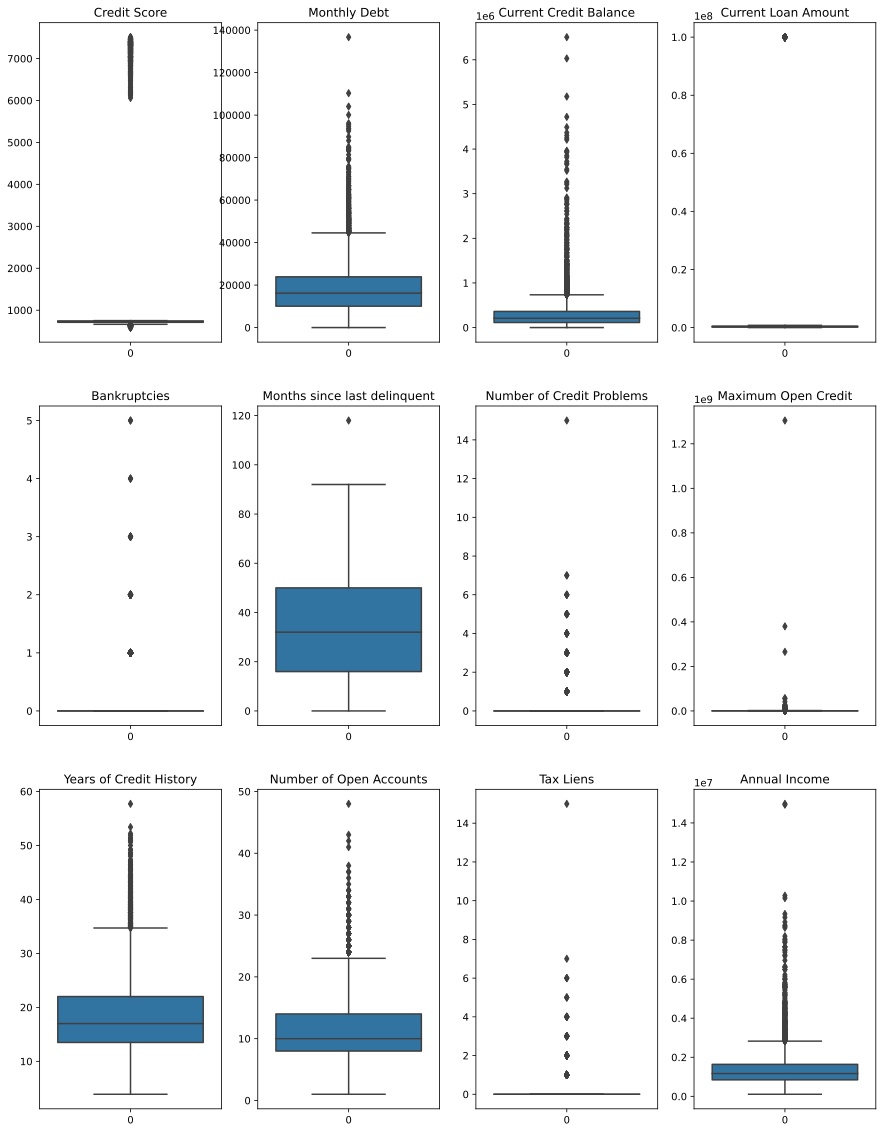

In [20]:
titles = all_data.select_dtypes(include='number').columns.to_list()

fig, axes = plt.subplots(3, 4, figsize=FIGSIZE)

for row in axes:
    for col in row:
        title = titles.pop()
        sns.boxplot(data=all_data[title], ax=col)
        col.set_title(title)

plt.show()

#### Examine Missing Values

Next we can look at the number and percentage of missing values in each column.

In [21]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [22]:
missing_values = missing_values_table(all_data)
missing_values.head()

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,5439,54.40
Annual Income,2070,20.70
Credit Score,2070,20.70
Years in current job,457,4.60
Bankruptcies,17,0.20


#### Clean Data

In [23]:
def years_current_job_clean(string):
    if isinstance(string, str):
        string = string.rstrip('s') \
                        .rstrip('year') \
                        .rstrip() \
                        .rstrip('+')
        
        if string.startswith('<'):
            string = '0'
        
    return string

In [24]:
def phaseclean(df):
    df['Years in current job'] = df['Years in current job'].map(years_current_job_clean)
    df['Years in current job'] = df['Years in current job'].astype(float)
    return df

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

#### Correlations

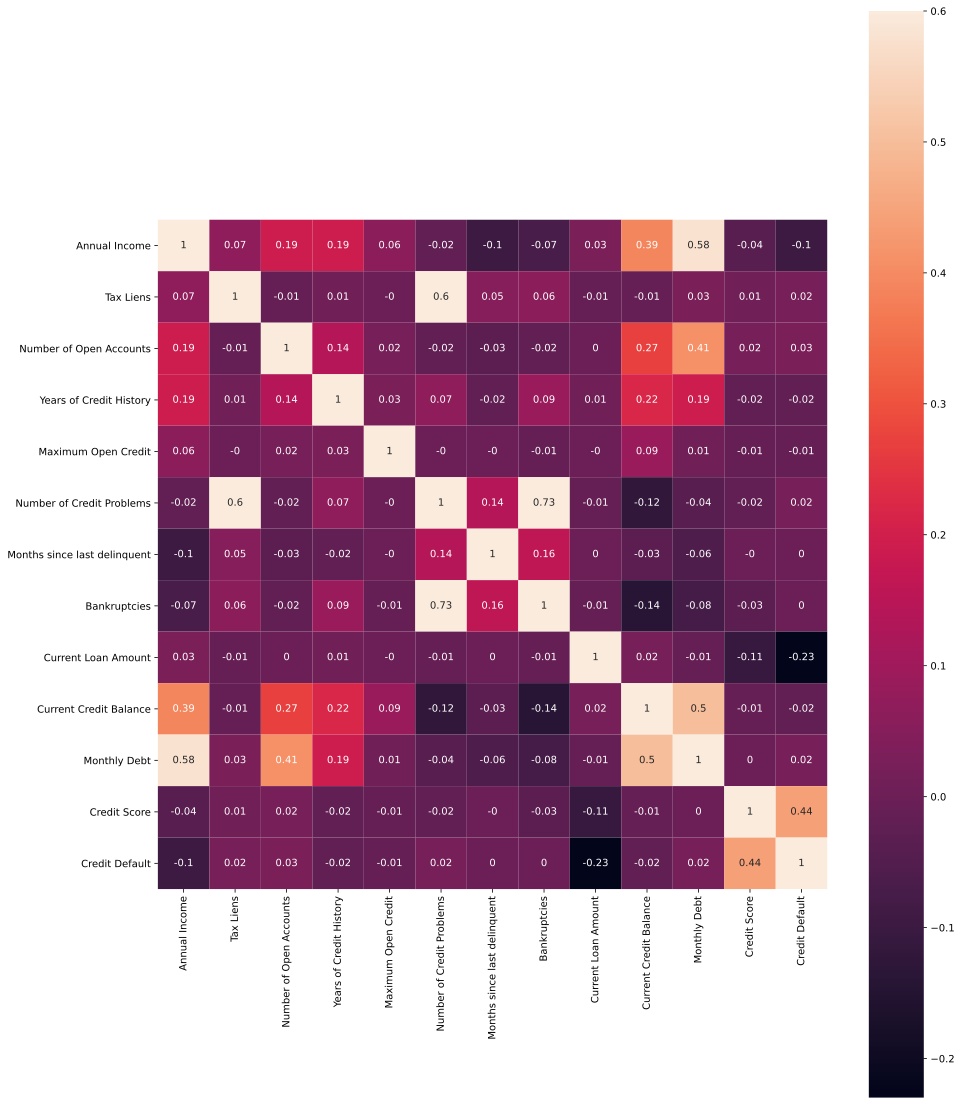

In [26]:
corrmat = train.loc[:, train.columns != 'Id'].corr().round(2)
plt.subplots(figsize=FIGSIZE)
sns.heatmap(corrmat, vmax=0.6, square=True, annot=True)

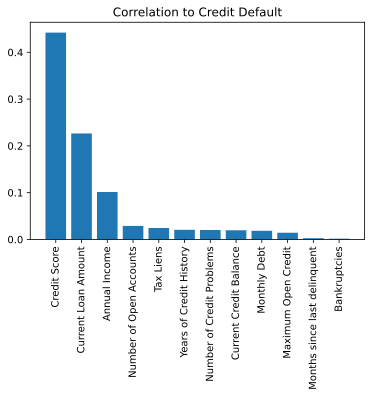

In [27]:
corrmat = train.loc[:, train.columns != 'Id'] \
    .corrwith(train[TARGET]) \
    .abs() \
    .sort_values(ascending=False)[1:]

plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Credit Default')
plt.xticks(rotation='vertical')
plt.show()

<a id=relations></a>
### Relations between features

In [29]:
FEATURES = list(train.drop([TARGET], axis=1))
NUM_FEATURES = list(train[FEATURES].select_dtypes(include='number'))

In [30]:
train[FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

<a id=missing></a>
### Missing values

In [31]:
def missing_values_clean(df):
    
    if pd.api.types.is_categorical_dtype(df['Years in current job']):
        df['Years in current job'] = df['Years in current job'].cat.add_categories(['0'])
    
    df['Years in current job'] = df['Years in current job'].fillna('0')

    df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)

    df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
    
    return df

In [32]:
train = missing_values_clean(train)
test = missing_values_clean(test)

In [33]:
missing_values = missing_values_table(train)
missing_values.head()

Your selected dataframe has 17 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Annual Income,1557,20.80
Credit Score,1557,20.80


In [34]:
missing_values = missing_values_table(test)
missing_values.head()

Your selected dataframe has 16 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Annual Income,513,20.50
Credit Score,513,20.50


<a id=encode></a>
### Preparing for modelling

#### One Hot Encoding

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7500 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  7500 non-null   float32 
 9   Bankruptcies                  7500 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [36]:
le = LabelEncoder() 

In [37]:
train['Home Ownership']= le.fit_transform(train['Home Ownership'])
test['Home Ownership']= le.fit_transform(test['Home Ownership']) 

train['Years in current job']= le.fit_transform(train['Years in current job'])
test['Years in current job']= le.fit_transform(test['Years in current job']) 

train['Purpose']= le.fit_transform(train['Purpose'])
test['Purpose']= le.fit_transform(test['Purpose']) 

train['Term']= le.fit_transform(train['Term'])
test['Term']= le.fit_transform(test['Term']) 

#### Data Normalization

In [38]:
scaler = StandardScaler()

In [39]:
df_norm = train.copy()
df_norm[NUM_FEATURES] = scaler.fit_transform(df_norm[NUM_FEATURES])
train = df_norm.copy()

In [40]:
df_norm = test.copy()
df_norm[NUM_FEATURES] = scaler.transform(df_norm[NUM_FEATURES])
test = df_norm.copy()

#### Missing values

In [41]:
train['Annual Income'] = train['Annual Income'].fillna(-999)
test['Annual Income'] = test['Annual Income'].fillna(-999)

In [42]:
train['Credit Score'] = train['Credit Score'].fillna(-999)
test['Credit Score'] = test['Credit Score'].fillna(-999)

#### Splitting the train sample

In [43]:
X = train[FEATURES]
y = train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

#### Target Balancing

In [44]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [45]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
df_balanced[TARGET].value_counts()
X_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]

<a id=model></a>
### Modelling

In [46]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [47]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [48]:
result_model_score = {}

#### Logistic Regression

In [49]:
model_lr = LogisticRegression(
    solver='liblinear', 
    penalty='l2',
    max_iter=160,
    class_weight='balanced',
    C=2,
)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_lr
model_score['model_name'] = 'model_lr'

result_model_score['Logistic Regression'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      3771
           1       0.62      0.66      0.64      2958

    accuracy                           0.67      6729
   macro avg       0.67      0.67      0.67      6729
weighted avg       0.68      0.67      0.67      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1616
           1       0.44      0.68      0.54       634

    accuracy                           0.67      2250
   macro avg       0.64      0.67      0.64      2250
weighted avg       0.73      0.67      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1079  537
1                205  429


#### K Nearest Neighbours

In [50]:
model_knn = KNeighborsClassifier(
    weights='uniform',
    p=1,
    n_neighbors=1,
    leaf_size=19,
    algorithm='ball_tree',
    n_jobs=-1,
)
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_knn
model_score['model_name'] = 'model_knn'
result_model_score['K Nearest Neighbours'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1616
           1       0.43      0.43      0.43       634

    accuracy                           0.68      2250
   macro avg       0.60      0.60      0.60      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1252  364
1                361  273


#### eXtreme Gradient Boosting - XGBoost

In [51]:
model_xgb = xgb.XGBClassifier(
    subsample=0.7,
    reg_alpha=0.08,
    n_estimators=750,
    min_child_weight=13,
    max_depth=4,
    learning_rate=0.36,
    gamma=1,
    colsample_bytree=0.8,
    colsample=0.5,
    n_jobs=-1,
    random_state=21
)

model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_xgb
model_score['model_name'] = 'model_xgb'
result_model_score['XGBoost'] = model_score

[21:50:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TRAIN

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3771
           1       0.99      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1616
           1       0.49      0.46      0.48       634

    accuracy                           0.72      2250
   macro avg       0.64      0.64      0.64      2250


#### LightGBM

In [52]:
model_lgbm = lgbm.LGBMClassifier(
    subsample=0.4,
    reg_lambda=0.0,
    reg_alpha=0.75,
    num_leaves=40,
    n_estimators=250,
    min_child_weight=0.05,
    max_depth=3,
    learning_rate=0.86,
    is_unbalance=True,
    boosting_type='gbdt',
    n_jobs=-1,
    random_state=21
)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['name'] = 'LightGBM'
model_score['model'] = model_lgbm
model_score['model_name'] = 'model_lgbm'
result_model_score['LightGBM'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3771
           1       0.96      0.99      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1616
           1       0.45      0.48      0.47       634

    accuracy                           0.69      2250
   macro avg       0.62      0.63      0.62      2250
weighted avg       0.70      0.69      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1243  373
1                327  307


#### CatBoost

In [53]:
model_catb = catb.CatBoostClassifier(
    od_type='IncToDec',
    n_estimators=1250,
    max_depth=3,
    learning_rate=0.66, 
    l2_leaf_reg=5,
    silent=True, 
    random_state=21,
)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_catb
model_score['model_name'] = 'model_catb'
result_model_score['CatBoost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1616
           1       0.49      0.44      0.46       634

    accuracy                           0.71      2250
   macro avg       0.64      0.63      0.63      2250
weighted avg       0.70      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1324  292
1                355  279


#### Ada Boost

In [54]:
model_ada = AdaBoostClassifier(
    n_estimators=400,
    learning_rate=0.86,
    algorithm='SAMME.R',
)
model_ada.fit(X_train, y_train)

y_train_pred = model_ada.predict(X_train)
y_test_pred = model_ada.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_ada
model_score['model_name'] = 'model_ada'
result_model_score['Ada Boost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      3771
           1       0.75      0.65      0.69      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.74      0.74      6729
weighted avg       0.75      0.75      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1616
           1       0.50      0.55      0.53       634

    accuracy                           0.72      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1269  347
1                284  350


#### Support Vector Machine

In [55]:
model_svm = SVC(
    C=0.5, 
    class_weight='balanced', 
    gamma='auto'
)
model_svm.fit(X_train, y_train)

y_train_pred = model_svm.predict(X_train)
y_test_pred = model_svm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_svm
model_score['model_name'] = 'model_svm'
result_model_score['Support Vector Machine'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      3771
           1       0.69      0.71      0.70      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.73      0.73      6729
weighted avg       0.73      0.73      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1616
           1       0.43      0.60      0.50       634

    accuracy                           0.67      2250
   macro avg       0.62      0.65      0.63      2250
weighted avg       0.71      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1117  499
1                252  382


#### Perceptron

In [56]:
model_pctr = Perceptron(class_weight='balanced')
model_pctr = model_pctr.fit(X_train, y_train)

y_train_pred = model_pctr.predict(X_train)
y_test_pred = model_pctr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_pctr
model_score['model_name'] = 'model_pctr'
result_model_score['Perceptron'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.35      0.49      3771
           1       0.52      0.91      0.66      2958

    accuracy                           0.59      6729
   macro avg       0.68      0.63      0.58      6729
weighted avg       0.70      0.59      0.57      6729

TEST

              precision    recall  f1-score   support

           0       0.89      0.34      0.49      1616
           1       0.35      0.90      0.50       634

    accuracy                           0.49      2250
   macro avg       0.62      0.62      0.49      2250
weighted avg       0.74      0.49      0.49      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               545  1071
1                66   568


#### Naive Bayes

In [57]:
model_bay = GaussianNB()
model_bay = model_bay.fit(X_train, y_train)

y_train_pred = model_bay.predict(X_train)
y_test_pred = model_bay.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_bay
model_score['model_name'] = 'model_bay'
result_model_score['Naive Bayes'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.18      0.30      3771
           1       0.49      0.99      0.65      2958

    accuracy                           0.54      6729
   macro avg       0.73      0.59      0.48      6729
weighted avg       0.76      0.54      0.46      6729

TEST

              precision    recall  f1-score   support

           0       0.98      0.18      0.30      1616
           1       0.32      0.99      0.48       634

    accuracy                           0.41      2250
   macro avg       0.65      0.58      0.39      2250
weighted avg       0.79      0.41      0.35      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               287  1329
1                 6   628


#### Extremely Randomised Trees

In [58]:
model_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=700,
    max_depth=7,
    min_samples_split=0.2,
    class_weight='balanced_subsample',
    )
model_ext = model_ext.fit(X_train, y_train)

y_train_pred = model_ext.predict(X_train)
y_test_pred = model_ext.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_ext
model_score['model_name'] = 'model_ext'
result_model_score['Extremely Randomised Trees'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.64      0.68      3771
           1       0.60      0.68      0.64      2958

    accuracy                           0.66      6729
   macro avg       0.66      0.66      0.66      6729
weighted avg       0.67      0.66      0.66      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1616
           1       0.44      0.68      0.53       634

    accuracy                           0.66      2250
   macro avg       0.64      0.67      0.64      2250
weighted avg       0.73      0.66      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1063  553
1                203  431


#### Gradient Boosting

In [59]:
model_gb = GradientBoostingClassifier(
            loss='exponential',
            n_estimators=225,
            learning_rate=1.4,
            max_depth=6,
            random_state=21)

model_gb.fit(X_train, y_train)

y_train_pred = model_gb.predict(X_train)
y_test_pred = model_gb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_gb
model_score['model_name'] = 'model_gb'
result_model_score['Gradient Boosting'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1616
           1       0.53      0.41      0.46       634

    accuracy                           0.73      2250
   macro avg       0.66      0.63      0.64      2250
weighted avg       0.71      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1385  231
1                374  260


#### Stacking / Ensemble methods

##### Voting Classifier

In [60]:
model_vote = VotingClassifier(
    estimators=[
        ('Logistic Regression', model_lr),
        ('Extremely Randomised Trees', model_ext),
        ('Support Vector Machine', model_svm),
        #('LightGBM', model_lgbm),
        ('Naive Bayes', model_bay),
        ('Gradient Boosting', model_gb),
        #('XGBoost', model_xgb),
        ('Ada Boost', model_ada),
        ('K Nearest Neighbours', model_knn),
        ('Perceptron', model_pctr)
    ],
    #weights=[3,3,2,3,1,1],
    voting='hard',
    n_jobs=-1)

model_vote.fit(X_train, y_train)

y_train_pred = model_vote.predict(X_train)
y_test_pred = model_vote.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_vote
model_score['model_name'] = 'model_vote'
result_model_score['Voting Classifier'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      3771
           1       0.78      0.84      0.81      2958

    accuracy                           0.83      6729
   macro avg       0.83      0.83      0.83      6729
weighted avg       0.83      0.83      0.83      6729

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1616
           1       0.48      0.63      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.68      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1179  437
1                237  397


#### Tunning models 

In [61]:
def select_model(df, features):
    all_X = df[features]
    all_y = df[TARGET]
    
    cv=KFold(n_splits=3, random_state=21, shuffle=True)
        
    LogisticRegression_dict = {
        'model_name': 'Logistic Regression',
        'estimator': LogisticRegression(),
        'hyperparams': {
            'C': np.arange(1, 5, 1),
            'class_weight': [None, 'balanced'],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'max_iter': np.arange(100, 200, 10)
        }
    }
    
    KNeighborsClassifier_dict = {
        'model_name': 'K Nearest Neighbours',
        'estimator': KNeighborsClassifier(),
        'hyperparams': {
            'algorithm': ['ball_tree', 'kd_tree', 'brute'],
            'leaf_size': np.arange(1, 20, 1),
            'n_neighbors': np.arange(1, 5, 1),
            'p': [1, 2],
            'weights': ['distance', 'uniform']
        }
    }
    
    XGBClassifier_dict = {
        'model_name': 'XGBoost',
        'estimator': xgb.XGBClassifier(),
        'hyperparams': { 
        'learning_rate': np.arange(0.01, 1.0, 0.05),
        'n_estimators': np.arange(200, 800, 50),
        'max_depth': np.arange(3, 10, 1),
        'min_child_weight': np.arange(5, 15, 1),
        'subsample': np.arange(0.7, 1.5, 1),
        'colsample': np.arange(0.5, 1.5, 0.1),
        'colsample_bytree': np.arange(0.5, 1.0, 0.1),
        'gamma': np.arange(0, 5, 1),
        'reg_alpha': np.arange(0.01, 0.1, 0.01)
        }  
    }
    
    LGBMClassifier_dict = {
        'model_name': 'LightGBM',
        'estimator': lgbm.LGBMClassifier(),
        'hyperparams': {
             'boosting_type': ['gbdt'],
             'learning_rate': np.arange(0.01, 1.0, 0.05),
             'max_depth': np.arange(3, 10, 1),
             'min_child_weight': np.arange(0.001, 1, 0.005),
             'n_estimators': np.arange(100, 500, 50),
             'num_leaves': np.arange(10, 50, 5),
             'reg_alpha': np.arange(0.0, 1.5, 0.05),
             'reg_lambda': np.arange(0.0, 1.0, 0.05),
             'subsample': np.arange(0.2, 1.0, 0.1),
             'is_unbalance': [True, False],
        }  
    }
    
    CatBoostClassifier_dict = {
        'model_name': 'CatBoost',
        'estimator': catb.CatBoostClassifier(silent=True),
        'hyperparams': {
             'max_depth': np.arange(1, 10, 1),
             'n_estimators': np.arange(500, 1500, 50),
             'learning_rate': np.arange(0.01, 1.0, 0.05),
             'od_type': ['IncToDec', 'Iter'],
             'l2_leaf_reg': [10, 100, 5],
        }  
    }
    
    AdaBoostClassifier_dict = {
        'model_name': 'Ada Boost',
        'estimator': AdaBoostClassifier(),
        'hyperparams': {
             'algorithm': ['SAMME', 'SAMME.R'],
             'learning_rate': np.arange(0.01, 1.0, 0.05),
             'n_estimators': np.arange(100, 1000, 50),
        }  
    }
    
    SVC_dict = {
        'model_name': 'Support Vector Machine',
        'estimator': SVC(),
        'hyperparams': { 
            'C': np.arange(0.5, 5, 0.5),
            'class_weight': ['balanced'],
            'gamma': np.arange(1, 5, 1),
            'kernel': ['rbf'],
        }  
    }
    
    ExtraTreesClassifier_dict = {
        'model_name': 'Extremely Randomised Trees',
        'estimator': ExtraTreesClassifier(),
        'hyperparams': { 
              'n_estimators': np.arange(100, 1000, 100),
              'min_samples_split': np.arange(0, 1, 0.1),
              'class_weight': ['balanced', 'balanced_subsample',  None],
              'max_depth': np.arange(1, 10, 1),
        }  
    }
    
    GradientBoostingClassifier_dict = {
        'model_name': 'Gradient Boosting',
        'estimator': GradientBoostingClassifier(),
        'hyperparams': { 
              'max_depth': np.arange(1, 10, 1),
              'n_estimators': np.arange(5, 500, 10),
              'learning_rate': np.arange(0.01, 10, 0.05),
        }  
    }
    
    hyper_params_list = [
        LogisticRegression_dict,
        KNeighborsClassifier_dict,
        XGBClassifier_dict,
        LGBMClassifier_dict,
        CatBoostClassifier_dict,
        AdaBoostClassifier_dict,
        SVC_dict,
        ExtraTreesClassifier_dict,
        GradientBoostingClassifier_dict,
    ]    
    
    scores = {}
    for model in hyper_params_list:
        print('-'*len(model['model_name']))
        print(model['model_name'])
        print('-'*len(model['model_name']))
        
        estimator = model['estimator']
        grid = RandomizedSearchCV(estimator, model['hyperparams'], scoring='f1', cv=cv, n_jobs=-1)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_ 
        model["best_model"] = grid.best_estimator_
        scores[model['model_name']] = grid.best_score_ 
        
        print('Best Score: ' + str(model['best_score']))
        print('Best Parameters: ' + str(model['best_params']))
    
    best_model = max(scores, key=scores.get)
    print('-'*len('Best Model: ' + str(best_model)))       
    print('Best Model: ' + str(best_model))
    print('-'*len('Best Model: ' + str(best_model)))   
    
    for model in hyper_params_list:
        if model['model_name'] == best_model:       
            print('Best Model Score: ' + str(model['best_score']))
            print('Best Model Parameters:' + str(model['best_params']))

    return hyper_params_list

In [62]:
# hyper_params_list = select_model(train, FEATURES)

#### Ranking of models and features

In [63]:
name_list = []
for name, model_score in result_model_score.items():
    name_list.append([
                    name, model_score['0']['f1-score'], \
                    model_score['1']['f1-score'], \
                    model_score['model_name'], \
                    model_score['model']
                     ])

In [64]:
models_score = pd.DataFrame(name_list, columns=[
                    'Name', \
                    'Score_0', \
                    'Score_1', \
                    'Model Name', \
                    'Model'
                    ],) \
                .sort_values(by='Score_1', ascending=False) \
                .reset_index(drop=True)
models_score

,Name,Score_0,Score_1,Model Name,Model
0,Voting Classifier,0.78,0.54,model_vote,VotingClassifier(estimators=[('Logistic Regres...
1,Logistic Regression,0.74,0.54,model_lr,"LogisticRegression(C=2, class_weight='balanced..."
2,Extremely Randomised Trees,0.74,0.53,model_ext,"(ExtraTreeClassifier(max_depth=7, min_samples_..."
3,Ada Boost,0.80,0.53,model_ada,"(DecisionTreeClassifier(max_depth=1, random_st..."
4,Support Vector Machine,0.75,0.50,model_svm,"SVC(C=0.5, class_weight='balanced', gamma='auto')"
5,Perceptron,0.49,0.50,model_pctr,Perceptron(class_weight='balanced')
6,Naive Bayes,0.30,0.48,model_bay,GaussianNB()
7,XGBoost,0.80,0.48,model_xgb,"XGBClassifier(base_score=0.5, booster='gbtree'..."
8,LightGBM,0.78,0.47,model_lgbm,"LGBMClassifier(is_unbalance=True, learning_rat..."
9,CatBoost,0.80,0.46,model_catb,<catboost.core.CatBoostClassifier object at 0x...


In [65]:
model_final = models_score.Model[0]
print(f'The best model is {models_score.Name[0]}')

The best model is Voting Classifier


In [66]:
y_test_pred_probs = model_lr.predict_proba(X_test)

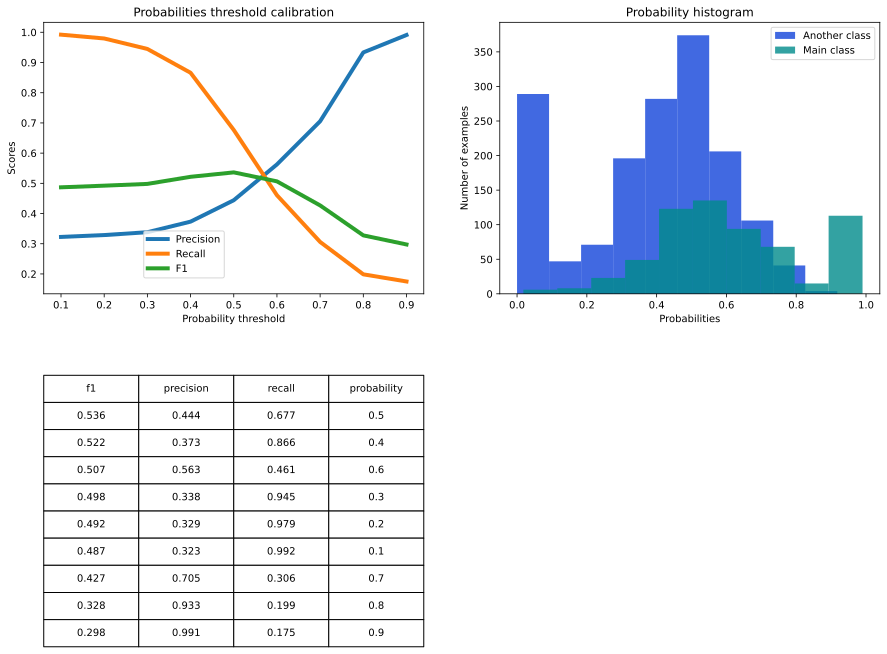

In [67]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

<a id=submit></a>
### Preparing our prediction for submission

In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   int64  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   int64  
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [69]:
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,3,-999.00,5,-0.11,-0.43,-0.83,-0.05,-0.34,2.39,-0.34,3,1,-0.37,-0.58,-0.96,-999.00
1,3,-1.34,1,-0.11,-1.05,2.04,-0.06,-0.34,-0.35,-0.34,4,1,-0.37,-0.77,-1.34,-0.28
2,1,-0.25,4,-0.11,-0.23,-0.66,-0.05,-0.34,-0.70,-0.34,3,1,-0.37,-0.45,0.03,3.81
3,1,-0.17,2,-0.11,0.99,-0.19,-0.03,-0.34,2.39,-0.34,3,1,-0.37,-0.24,0.78,-0.26
4,1,1.15,7,-0.11,-0.03,0.75,0.02,-0.34,-0.70,-0.34,3,0,-0.35,0.43,2.04,-0.28


In [70]:
default_pred = model_final.predict(test[FEATURES])

In [82]:
A = np.arange(0, 2500, 1)
submit = pd.DataFrame({'Id': A,'Credit Default': default_pred.T})
submit['Credit Default'].value_counts()
submit.head()


,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0


In [83]:
submit.to_csv('Elizarova_sub.csv', index=False)